In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

from sklearn.ensemble import RandomForestClassifier
#from sklearn import tree
#from sklearn.inspection import permutation_importance

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [2]:
# this script takes in:
# - the position of the switch,
# - and the voltages V0 and V1
# to assess the health of the circuit. 

# The quantification of the health of the circuit may be dichotomous (up/down), but it may also take multiple states F1,...,Fn
# Therfore, this health assessment may be framed as a classification problem

In [3]:
# a set of training data consists of inputs (S, V0, V1) and outputs (Health, F1,...Fn)

In [4]:
def readfile(bestand):
    table = None
    table = pd.read_excel(bestand, index_col=0)
    
    table.loc[:,['S','V0','V1']] = table.loc[:,['S','V0','V1']].astype('float64', errors="ignore") #it appears that some Voltages came in as an integer and that sucks...
    table.loc[:,['F1','F2','F3','F4']] = table.loc[:,['F1','F2','F3','F4']].astype('bool', errors="ignore")
    
    table.loc[:,'Health'] = ~(table.loc[:,['F1','F2','F3','F4']]).any(axis='columns', bool_only=True)
    
    return table

In [5]:
def plotlabels(table, by, legendtitle, title):
    dum = table.groupby(by)[['S','V0','V1']]
    fig = plt.figure(figsize = (6,6))
    plt.rcParams['font.size']=14
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.set_xlabel('V0'), ax.set_ylabel('V1'),ax.set_zlabel('S')
    ax.set_xlim(0,5),    ax.set_ylim(0,5),   ax.set_zlim(0,1)
    ax.set_title(title)

    for i in dum.groups:
        du = dum.get_group(i)

        S = du.loc[:,'S']
        V0 = du.loc[:,'V0']
        V1 = du.loc[:,'V1']
       # np.random.seed(int(V0.mean()*10))
        ax.scatter3D(V0,V1,S, zdir='z', color=np.random.rand(1,3), 
                     marker='v', 
                     label = str(i), 
                         s=V0.mean()*150+5)
    
    ax.legend(loc='right', bbox_to_anchor=(1.8, 0.8), title = legendtitle)
    ax.view_init(elev=25, azim=35)#, roll=0)
    
    return

In [6]:
# fit a RF model and determine gini importance

def selectRFmodel(XX,y):
    imputer = KNNImputer(n_neighbors=3, weights="distance")
    XX = imputer.fit_transform(XX)
    
    rfmodel = RandomForestClassifier(n_estimators = 40, criterion="gini",random_state = None)
    
    return rfmodel.fit(XX, y), rfmodel.feature_importances_

In [7]:
# find inertia of k means clustering

def get_inert(kk, XX):
    kmeanModel = KMeans(n_clusters=kk, n_init=10)
    kmeanModel.fit(XX)
    inert = kmeanModel.inertia_
    
    return inert, kmeanModel


In [8]:
# perform k means clustering while inertia reduction is sufficiently large

def vl_regime(XX):
    imputer = KNNImputer(n_neighbors=3, weights="distance")
    XX = imputer.fit_transform(XX)

    scaler=StandardScaler()                                  # transpose the dataframe while disposing the first non-numerical column
    Xtrans = scaler.fit_transform(XX)   
    
    k = 2
    INERT0, KMM0 = get_inert(1, Xtrans)
    INERT1, KMM1 = get_inert(2, Xtrans)

    while (INERT1/INERT0<0.8)&(INERT1>1):
        k = k + 1
        INERT0 = INERT1
        KMM0 = KMM1
        INERT1, KMM1 = get_inert(k, Xtrans)
    
    OOregime = KMM0.predict(Xtrans)                    # cluster the timeseries of vl
    OOcenters = scaler.inverse_transform( 
        pd.DataFrame(KMM0.cluster_centers_ ))          # infer cluster centers
        
    return scaler, KMM0, OOregime, OOcenters


In [9]:
#load the balanced and complete training data in a pandas dataframe

#df_bc = readfile("C:/Users/Admin/Pythonprojects/RAMS/data/Arduino_trainingset_BalancedComplete.xlsx")
df_bc = readfile("https://raw.githubusercontent.com/chrisrijsdijk/RAMS/master/data/Arduino_trainingset_BalancedComplete.xlsx")

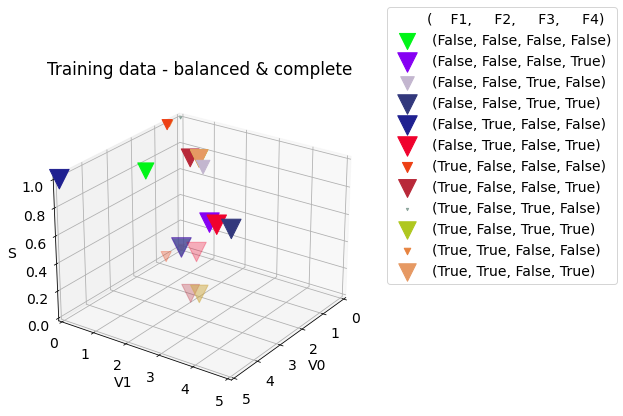

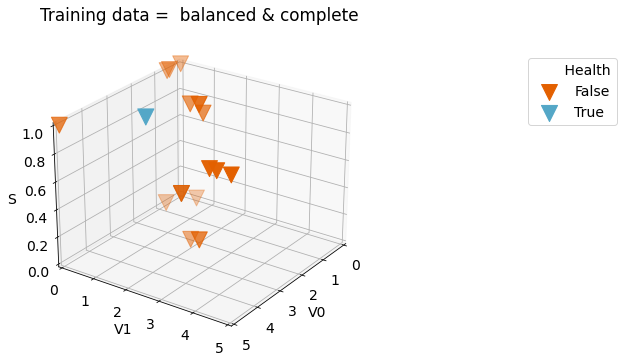

In [10]:
# plot the training data and their labels

plotlabels(df_bc,                                          # data frame
           ['F1','F2','F3','F4'],                          # specify the labels to groupby
          '      (    F1,     F2,     F3,     F4)',        # title of the legend
           'Training data - balanced & complete'           # title of graph
          )

plotlabels(df_bc,                                          # data frame
           ['Health'],                                     # specify the labels to groupby
          '       Health',                                 # title of the legend
           'Training data =  balanced & complete'          # title of graph
          )


In [11]:
plt.close('all')

In [12]:
#load the unbalanced and incomplete training data in a pandas dataframe

df = None

#df_ui =readfile("C:/Users/Admin/Pythonprojects/RAMS/data/Arduino_trainingset_UnbalancedIncomplete.xlsx")
df_ui = readfile("https://raw.githubusercontent.com/chrisrijsdijk/RAMS/master/data/Arduino_trainingset_UnbalancedIncomplete.xlsx")

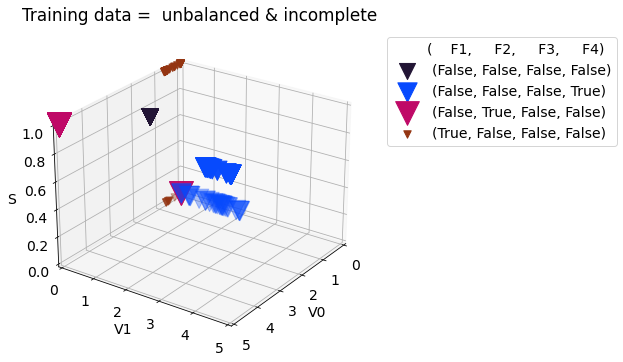

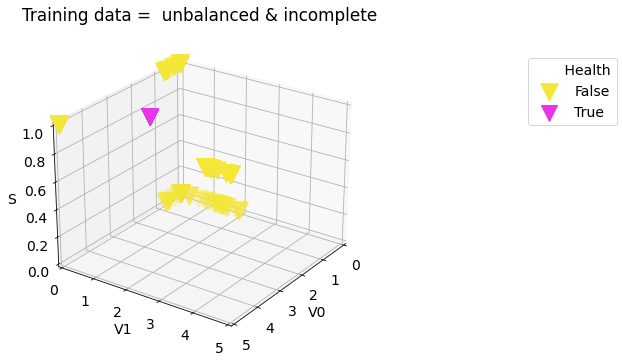

In [13]:
# plot the training data and their labels

plotlabels(df_ui,                                          # data frame
           ['F1','F2','F3','F4'],                          # specify the labels to groupby
          '      (    F1,     F2,     F3,     F4)',        # title of the legend
           'Training data =  unbalanced & incomplete'      # title of graph
          )

plotlabels(df_ui,                                          # data frame
           ['Health'],                                     # specify the labels to groupby
          '       Health',                                 # title of the legend
           'Training data =  unbalanced & incomplete'      # title of graph
          )


In [14]:
plt.close('all')

In [15]:
# infer RF models from df_bc data

X = df_bc.iloc[:,[0,1,2]]                    #define the explanatory variables
X_names = df_bc.iloc[:,[0,1,2]].columns      #load a string of column names to label the output of the random forest model afterwards...

rf_bc_f1_model, rf_bc_f1_featimp = selectRFmodel(X, np.array(df_bc["F1"].astype('float')))
rf_bc_f2_model, rf_bc_f2_featimp = selectRFmodel(X, np.array(df_bc["F2"].astype('float')))
rf_bc_f3_model, rf_bc_f3_featimp = selectRFmodel(X, np.array(df_bc["F3"].astype('float')))
rf_bc_f4_model, rf_bc_f4_featimp = selectRFmodel(X, np.array(df_bc["F4"].astype('float')))

rf_bc_health_model, rf_bc_health_featimp = selectRFmodel(X, np.array(df_bc["Health"].astype('float')))


In [16]:
# infer RF models from df_ui data

X = df_ui.iloc[:,[0,1,2]]                    #define the explanatory variables
X_names = df_ui.iloc[:,[0,1,2]].columns        #load a string of column names to label the output of the random forest model afterwards...

rf_ui_f1_model, rf_ui_f1_featimp = selectRFmodel(X, np.array(df_ui["F1"].astype('float')))
rf_ui_f2_model, rf_ui_f2_featimp = selectRFmodel(X, np.array(df_ui["F2"].astype('float')))
rf_ui_f3_model, rf_ui_f3_featimp = selectRFmodel(X, np.array(df_ui["F3"].astype('float')))
rf_ui_f4_model, rf_ui_f4_featimp = selectRFmodel(X, np.array(df_ui["F4"].astype('float')))

rf_ui_health_model, rf_ui_health_featimp = selectRFmodel(X, np.array(df_ui["Health"].astype('float')))


In [17]:
# plot the importance of the various explanatory variables using Gini importance
# Gini importance is a number between zero and one, the heigher the Gini importance the better the explanatory variable can predict the failure y 

featureImportances = np.array([rf_bc_f1_model.feature_importances_, 
                               rf_bc_f2_model.feature_importances_, 
                               rf_bc_f3_model.feature_importances_, 
                               rf_bc_f4_model.feature_importances_,
                               rf_bc_health_model.feature_importances_,
                               
                               rf_ui_f1_model.feature_importances_, 
                               rf_ui_f2_model.feature_importances_, 
                               rf_ui_f3_model.feature_importances_, 
                               rf_ui_f4_model.feature_importances_,
                               rf_ui_health_model.feature_importances_
                              ])

pd.DataFrame(featureImportances, columns = X_names, index = ["bc_F1","bc_F2","bc_F3","bc_F4","bc_Health",
                                                            "ui_F1","ui_F2","ui_F3","ui_F4","ui_Health"])

,S,V0,V1
bc_F1,0.098684,0.577922,0.323394
bc_F2,0.097864,0.404406,0.497730
bc_F3,0.130710,0.408790,0.460500
bc_F4,0.060784,0.362709,0.576507
bc_Health,0.120440,0.515890,0.363670
ui_F1,0.165143,0.681816,0.153041
ui_F2,0.026067,0.521037,0.452896
ui_F3,0.000000,0.000000,0.000000
ui_F4,0.059609,0.115906,0.824485
ui_Health,0.108112,0.431639,0.460250


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


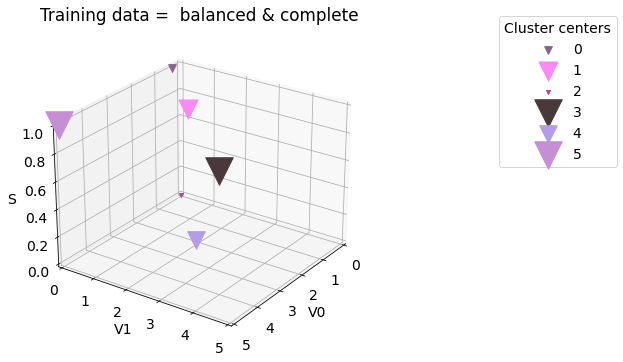

In [18]:
# infer KM model from df_bc data

X = df_bc.iloc[:,[0,1,2]]                    #define the explanatory variables
X_names = df_bc.iloc[:,[0,1,2]].columns      #load a string of column names to label the output of the random forest model afterwards...

df_bc_scaler, df_bc_KMM, df_bc_regime, df_bc_centers = vl_regime(X)

df_bc_cluster = pd.DataFrame(df_bc_centers, columns=X_names)
plotlabels(df_bc_cluster,                          # data frame
           list(df_bc_cluster.index),              # specify the labels to groupby
           'Cluster centers',                      # title of the legend
           'Training data =  balanced & complete'  # title of graph
          )

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


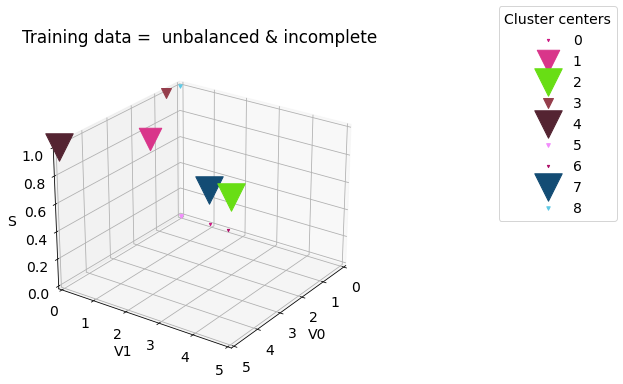

In [19]:
# infer KM model from df_ui data

X = df_ui.iloc[:,[0,1,2]]                    #define the explanatory variables
X_names = df_ui.iloc[:,[0,1,2]].columns      #load a string of column names to label the output of the random forest model afterwards...

df_ui_scaler, df_ui_KMM, df_ui_regime, df_ui_centers = vl_regime(X)

df_ui_cluster = pd.DataFrame(df_ui_centers, columns=X_names)
plotlabels(df_ui_cluster,                              # data frame
           list(df_ui_cluster.index),                  # specify the labels to groupby
           'Cluster centers',                           # title of the legend
           'Training data =  unbalanced & incomplete'  # title of graph
          )

In [20]:
#confront the various model with the validation data

In [21]:
# fit assess data to some k_means cluster

def fitKMeans(scaler, model, data):
    datatrans = scaler.transform(data)
    clusterlabel = model.predict(datatrans)
    clustercentertrans = model.cluster_centers_[clusterlabel]
    clustercenter = scaler.inverse_transform(clustercentertrans)
    distance = np.linalg.norm(data-clustercenter)
    
    return np.array([distance])
    

In [22]:
import serial
import time
import keyboard
from IPython.display import clear_output

In [23]:
# connect to Arduino

ser = serial.Serial('COM3', 9600, timeout=1) #check whether the Arduino is really connected with COM3 or adjust the code to the correct COM
                                             #check at settings and check whether Arduino is a connected device
time.sleep(2)

In [24]:
# read write the serial connection at a given sampling rate

def write_read(x):                  #this function takes an input x, which is a switch command and it returns data from the Arduino
    ser.write(bytes(x, 'utf-8'))    #pass the command to Arduino by the serial connection
#    time.sleep(0.05)                #give it some time
    data = ser.readline()           #take data from Arduino
    return data                     #return the data to be processed further

In [ ]:
# start to control the Arduino while collecting the data

i= True                                       #this boolean allows to interrupt the data collection
num ='0'
result = ()

while i:                                      # making a loop continues as long as i is true. This loop involves a cycle of reading and evaluating data
    clear_output(wait=True)
    print("Press <1> to switch power on")
    print("Press <0> to switch power off")
    print("Press <q> to quit")
    print("#########################################################")
          
    print('time:                                         ',str(pd.to_datetime(round(time.time(), 0),unit = 's')))
    print('.........................................................')
    
    try:
        print('position of the switch S:                     ',dum5[0][0])
        print('voltage V0:                                   ',dum5[0][1])
        print('voltage V1:                                   ',dum5[0][2])
        print('.........................................................')

        print('diagnostics of F1 by rf_bc: ',rf_bc_f1_model.predict(dum5))
        print('diagnostics of F2 by rf_bc: ',rf_bc_f2_model.predict(dum5))
        print('diagnostics of F3 by rf_bc: ',rf_bc_f3_model.predict(dum5))
        print('diagnostics of F4 by rf_bc: ',rf_bc_f4_model.predict(dum5))
        print('Health by rf_bc',rf_bc_health_model.predict(dum5))
            
        print('Distance to nearest training_bc data: ',fitKMeans(df_bc_scaler, df_bc_KMM, dum5),' Volts')
            
        print('.........................................................')

        print('diagnostics of F1 by rf_ui:   ',rf_ui_f1_model.predict(dum5))
        print('diagnostics of F2 by rf_ui:   ',rf_ui_f2_model.predict(dum5))
        print('diagnostics of F3 by rf_ui:   ',rf_ui_f3_model.predict(dum5))
        print('diagnostics of F4 by rf_ui:   ',rf_ui_f4_model.predict(dum5))
        print('Health by rf_ui',rf_ui_health_model.predict(dum5))
        
        print('Distance to nearest training_ui data: ',fitKMeans(df_ui_scaler, df_ui_KMM, dum5),' Volts')        
        
    except:
        print(' ')
        
    
    if keyboard.is_pressed('q'):              # if key 'q' is pressed 
        print('')
        print('You Pressed <q>uit!')
        i = False                             # finishing the loop
        
    elif keyboard.is_pressed('0'):            # if key '0' is pressed
        num = '0'                             # this represents the opening of the switch
        
    elif keyboard.is_pressed('1'):            # if key '1' is pressed
        num = '1'                             # this represents the closing of the switch
        
    else:
        value = write_read(num)               # if user did anything else then pressing 'q','0' or '1', the loop proceeds with collecting data

        dummy = value.decode().rstrip().split()                                     # transform the byte values that came in...
        dum4 = np.array([[int(dummy[0])]])                                          # .. to a binary for S and ...
        dum5 = np.array([np.append(dum4,[int(j)/1023*5 for j in dummy[1:]]  )])     #...some floats for V 
    
ser.close()       #close the serial port when the reading is stopped. If not done, reconnection with the Arduino is not possible

Press <1> to switch power on
Press <0> to switch power off
Press <q> to quit
#########################################################
time:                                          2024-07-31 15:46:07
.........................................................
position of the switch S:                      1.0
voltage V0:                                    2.4486803519061584
voltage V1:                                    2.287390029325513
.........................................................
diagnostics of F1 by rf_bc:  [0.]
diagnostics of F2 by rf_bc:  [0.]
diagnostics of F3 by rf_bc:  [1.]
diagnostics of F4 by rf_bc:  [0.]
Health by rf_bc [0.]
Distance to nearest training_bc data:  [0.3737545]  Volts
.........................................................
diagnostics of F1 by rf_ui:    [0.]
diagnostics of F2 by rf_ui:    [0.]
diagnostics of F3 by rf_ui:    [0.]
diagnostics of F4 by rf_ui:    [0.]
Health by rf_ui [1.]
Distance to nearest training_ui data:  [1.19609774]  Volts


# 